# Hyperspectral Images
(Simultaneously acquired 2D images)

**Suhas Somnath**

10/12/2018

**This example illustrates how a set of *simultaneously acquired* 2D grayscale images would be represented in the
Universal Spectroscopy and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**
This example is based on the popular Atomic Force Microscopy scan mode where multiple sensors *simultaneously* acquire
a value at each position on a 2D grid, thereby resulting in a 2D image per sensor. Specifically, the goal of this
example is to demonstrate the sharing of ``Ancillary`` datasets among multiple ``Main`` datasets.

This document is intended as a supplement to the explanation about the [USID model](../../usid_model.html)

Please consider downloading this document as a Jupyter notebook using the button at the bottom of this document.

Prerequisites:
--------------
We recommend that you read about the [USID model](../../usid_model.html)

We will be making use of the ``pyUSID`` package at multiple places to illustrate the central point. While it is
recommended / a bonus, it is not absolutely necessary that the reader understands how the specific ``pyUSID`` functions
work or why they were used in order to understand the data representation itself.
Examples about these functions can be found in other documentation on pyUSID and the reader is encouraged to read the
supplementary documents.

### Import all necessary packages
The main packages necessary for this example are ``h5py``, ``matplotlib``, and ``sidpy``, in addition to ``pyUSID``:

In [1]:
import subprocess
import sys
import os
import matplotlib.pyplot as plt
from warnings import warn
import h5py

%matplotlib inline

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
    import sidpy
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import sidpy
    import pyUSID as usid

Download the dataset
---------------------
As mentioned earlier, this image is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:



In [2]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/SingFreqPFM_0003.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Open the file
-------------
Lets open the file and look at its contents using
[sidpy.hdf_utils.print_tree()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#print_tree())

In [3]:
h5_file = h5py.File(h5_path, mode='r')
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Channel_002
    -----------
    ├ Raw_Data
  ├ Channel_003
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values


Notice that this file has multiple [Channel](../../usid_model.html#channels), each with a dataset named
``Raw_Data``. Are they all [Main Dataset](../../usid_model.html#main-datasets) datasets?
There are multiple ways to find out this. One approach is simply to ask pyUSID to list out all available ``Main``
datasets.

Visualize the contents in each of these channels
------------------------------------------------



In [4]:
for main_dset in usid.hdf_utils.get_all_main(h5_file):
    print(main_dset)
    print('---------------------------------------------------------------\n')

<HDF5 dataset "Raw_Data": shape (16384, 1), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	HeightRetrace (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	arb - size: 1
Data Type:
	float32
---------------------------------------------------------------

<HDF5 dataset "Raw_Data": shape (16384, 1), type "<f4">
located at: 
	/Measurement_000/Channel_001/Raw_Data 
Data contains: 
	AmplitudeRetrace (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	arb - size: 1
Data Type:
	float32
---------------------------------------------------------------

<HDF5 dataset "Raw_Data": shape (16384, 1), type "<f4">
located at: 
	/Measurement_000/Channel_002/Raw_Data 
Data contains: 
	DeflectionRetrace (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	arb

From the print statements above, it is clear that each of these ``Raw_Data`` datasets were indeed ``Main`` datasets.
How can these datasets be ``Main`` if they are not co-located with the corresponding sets of ``Ancillary`` datasets
within each ``Channel`` group?

Sharing Ancillary Datasets
--------------------------
Since each of the ``Main`` datasets have the same position and spectroscopic dimensions, they share the same
set of ancillary datasets that are under ``Measurement_000`` group. This is common for Scanning Probe Microscopy
scans where information from multiple sensors are recorded **simultaneously** during the scan.

Recall from the USID documentation that:

1. Multiple ``Main`` datasets can share the same ``Ancillary`` datasets
2. The ``Main`` datasets only need to have ``attributes`` named ``Position_Indices``, ``Position_Values``,
   ``Spectroscopic_Indices``, and ``Spectroscopic_Values``with the value set to the reference of the corresponding
   ``Ancillary`` datasets

We can investigate if this is indeed the case here. Lets get the references to ``Ancillary`` datasets linked to each
of the ``Main`` datasets:



In [5]:
for main_dset in usid.hdf_utils.get_all_main(h5_file):
    print('Main Dataset: {}'.format(main_dset.name))
    print('Position Indices: {}'.format(main_dset.h5_pos_inds.name))
    print('Position Values: {}'.format(main_dset.h5_pos_vals.name))
    print('Spectroscopic Indices: {}'.format(main_dset.h5_spec_inds.name))
    print('Spectroscopic Values: {}'.format(main_dset.h5_spec_vals.name))
    print('---------------------------------------------------------------\n')

Main Dataset: /Measurement_000/Channel_000/Raw_Data
Position Indices: /Measurement_000/Position_Indices
Position Values: /Measurement_000/Position_Values
Spectroscopic Indices: /Measurement_000/Spectroscopic_Indices
Spectroscopic Values: /Measurement_000/Spectroscopic_Values
---------------------------------------------------------------

Main Dataset: /Measurement_000/Channel_001/Raw_Data
Position Indices: /Measurement_000/Position_Indices
Position Values: /Measurement_000/Position_Values
Spectroscopic Indices: /Measurement_000/Spectroscopic_Indices
Spectroscopic Values: /Measurement_000/Spectroscopic_Values
---------------------------------------------------------------

Main Dataset: /Measurement_000/Channel_002/Raw_Data
Position Indices: /Measurement_000/Position_Indices
Position Values: /Measurement_000/Position_Values
Spectroscopic Indices: /Measurement_000/Spectroscopic_Indices
Spectroscopic Values: /Measurement_000/Spectroscopic_Values
------------------------------------------

From above, we see that all the ``Main`` datasets we indeed referencing the same set of ``Ancillary`` Datasets.
Note that it would **not** have been wrong to store (duplicate copies of) the ``Ancillary`` datasets within each
``Channel`` group. The data was stored in this manner since it is more efficient and because it was known *apriori*
that all ``Main`` datasets are dimensionally equal. Also note that this sharing of ``Ancillary`` datasets is OK even
though the physical quantity and units within each ``Main`` dataset are different since these two pieces of
information are stored in the attributes of the ``Main`` datasets (which are unique and independent) and not in the
``Ancillary`` datasets.

The discussion regarding the contents of the ``Ancillary`` datasets are identical to that for the [2D grayscale
image](./image.html) and will not be discussed here for brevity.

Visualizing the contents within each channel
--------------------------------------------
Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in
[visualize()](../user_guide/usi_dataset.html#Interactive-Visualization) function.

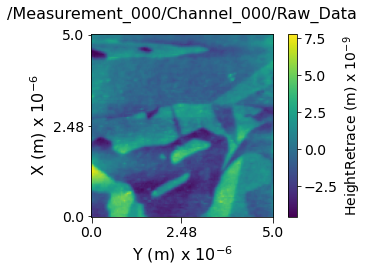

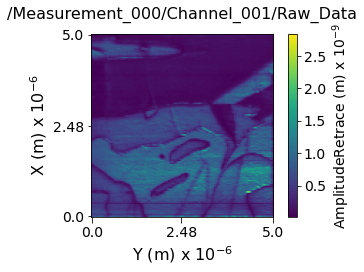

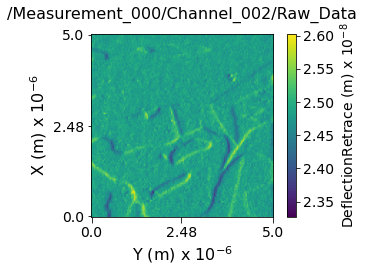

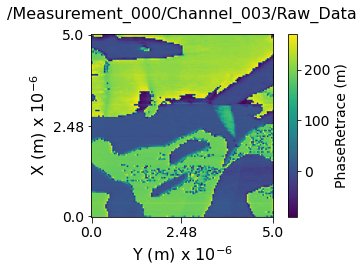

In [6]:
usid.plot_utils.use_nice_plot_params()
for main_dset in usid.hdf_utils.get_all_main(h5_file):
    main_dset.visualize(num_ticks=3)

Clean up
--------
Finally lets close and delete the example HDF5 file



In [7]:
h5_file.close()
os.remove(h5_path)